# Comparing the performance of optimizers - analysis

In [1]:
import pennylane as qml
import numpy as np
from qiskit import IBMQ
import itertools
import matplotlib.pyplot as plt
import pickle
import scipy

## Hardware-friendly circuit

In [2]:
n_wires = 5

In [3]:
n_shots_list = [10, 100, 1000]
devs = [qml.device("default.qubit", wires=n_wires, shots=shots, analytic=False) for shots in n_shots_list]
devs.append(qml.device("default.qubit", wires=n_wires))

In [4]:
devs

[<DefaultQubit device (wires=5, shots=10) at 0x7f939e033290>,
 <DefaultQubit device (wires=5, shots=100) at 0x7f93b291f650>,
 <DefaultQubit device (wires=5, shots=1000) at 0x7f939d084350>,
 <DefaultQubit device (wires=5, shots=1000) at 0x7f939d3666d0>]

In [5]:
def layers_circ(weights):
    for i in range(n_wires):
        qml.RX(weights[i], wires=i)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 1])
    qml.CNOT(wires=[3, 1])
    qml.CNOT(wires=[4, 3])
    return qml.expval(qml.PauliZ(1))

In [6]:
layers = [qml.QNode(layers_circ, d) for d in devs]

In [7]:
seed = 2

weights = qml.init.basic_entangler_layers_uniform(n_layers=1, n_wires=5, seed=seed).flatten()
weights

tensor([2.73943676, 0.16289932, 3.4536312 , 2.73521126, 2.6412488 ], requires_grad=True)

In [8]:
grads = [qml.grad(l, argnum=0) for l in layers]

In [9]:
[l(weights) for l in layers]

[-1.0, -0.8, -0.794, -0.7938055593697134]

In [10]:
g_exact = np.round(grads[-1](weights), 7)
g_exact

array([-0.3376347,  0.1304665,  0.2560632, -0.3416029,  0.       ])

## Calculating the Hessian

In [11]:
s = 0.5 * np.pi
denom = 4 * np.sin(s) ** 2
shift = np.eye(len(weights))


def hess_gen_results(func, weights, args=None):
    
    results = {}
    
    if not args:
        args = len(weights)
    
    for c in itertools.combinations(range(args), r=2):
        weights_pp = weights + s * (shift[c[0]] + shift[c[1]])
        weights_pm = weights + s * (shift[c[0]] - shift[c[1]])
        weights_mp = weights - s * (shift[c[0]] - shift[c[1]])
        weights_mm = weights - s * (shift[c[0]] + shift[c[1]])

        f_pp = func(weights_pp)
        f_pm = func(weights_pm)
        f_mp = func(weights_mp)
        f_mm = func(weights_mm)
        results[c] = (f_pp, f_mp, f_pm, f_mm)
    
    f = func(weights)
    
    for i in range(args):
        f_p = func(weights + 0.5 * np.pi * shift[i])
        f_m = func(weights - 0.5 * np.pi * shift[i])
        results[(i, i)] = (f_p, f_m, f)

    return results


def hess_diag_gen_results(func, weights, args=None):
    
    results = {}
    
    if not args:
        args = len(weights)
    
    f = func(weights)
    
    for i in range(args):
        f_p = func(weights + 0.5 * np.pi * shift[i])
        f_m = func(weights - 0.5 * np.pi * shift[i])
        results[(i, i)] = (f_p, f_m, f)

    return results


def grad_gen_results(func, weights, args=None):
    results = {}
    
    if not args:
        args = len(weights)
    
    for i in range(args):
        f_p = func(weights + 0.5 * np.pi * shift[i])
        f_m = func(weights - 0.5 * np.pi * shift[i])
        results[i] = (f_p, f_m)
    
    return results


def get_hess_diag(func, weights, args=None):
    if not args:
        args = len(weights)
        
    hess = np.zeros(args)
    results = hess_diag_gen_results(func, weights, args)
    
    for i in range(args):
        r = results[(i, i)]
        hess[i] = (r[0] + r[1] - 2 * r[2]) / 2
    
    grad = np.zeros(args)
    
    for i in range(args):
        r = results[(i, i)]
        grad[i] = (r[0] - r[1]) / 2
    
    return hess, results, grad


def get_grad(func, weights, args=None):
    
    if not args:
        args = len(weights)
    
    grad = np.zeros(args)
    results = grad_gen_results(func, weights, args)
    
    for i in range(args):
        r = results[i]
        grad[i] = (r[0] - r[1]) / 2
    
    return results, grad
    
    
def get_hess(func, weights, args=None):
    
    if not args:
        args = len(weights)
        
    hess = np.zeros((args, args))
    
    results = hess_gen_results(func, weights, args)
    
    for c in itertools.combinations(range(args), r=2):
        r = results[c]
        hess[c] = (r[0] - r[1] - r[2] + r[3]) / denom
    
    hess = hess + hess.T
    
    for i in range(args):
        r = results[(i, i)]
        hess[i, i] = (r[0] + r[1] - 2 * r[2]) / 2
    
    grad = np.zeros(args)
    
    for i in range(args):
        r = results[(i, i)]
        grad[i] = (r[0] - r[1]) / 2
    
    return hess, results, grad

In [12]:
hess_ps = get_hess(layers[-1], weights)
print(np.around(hess_ps[0], 3))
print(np.around(hess_ps[2], 3))
print(np.allclose(g_exact, hess_ps[2]))

[[ 0.794  0.055  0.109 -0.145  0.   ]
 [ 0.055  0.794 -0.042  0.056 -0.   ]
 [ 0.109 -0.042  0.794  0.11   0.   ]
 [-0.145  0.056  0.11   0.794  0.   ]
 [ 0.    -0.     0.     0.    -0.   ]]
[-0.338  0.13   0.256 -0.342  0.   ]
True


In [13]:
hess_ps = get_hess_diag(layers[-1], weights)
print(np.around(hess_ps[0], 3))
print(np.around(hess_ps[2], 3))
print(np.allclose(g_exact, hess_ps[2]))

[ 0.794  0.794  0.794  0.794 -0.   ]
[-0.338  0.13   0.256 -0.342  0.   ]
True


In [14]:
grad_ps = get_grad(layers[-1], weights)
print(np.around(grad_ps[1], 3))
print(np.allclose(g_exact, grad_ps[1]))

[-0.338  0.13   0.256 -0.342  0.   ]
True


Test with just first two params

In [15]:
hess_ps = get_hess(layers[-1], weights, 2)
print(np.around(hess_ps[0], 3))
print(np.around(hess_ps[2], 3))
print(np.allclose(g_exact[:2], hess_ps[2]))

[[0.794 0.055]
 [0.055 0.794]]
[-0.338  0.13 ]
True


In [16]:
hess_ps = get_hess_diag(layers[-1], weights, 2)
print(np.around(hess_ps[0], 3))
print(np.around(hess_ps[2], 3))
print(np.allclose(g_exact[:2], hess_ps[2]))

[0.794 0.794]
[-0.338  0.13 ]
True


In [17]:
grad_ps = get_grad(layers[-1], weights, 2)
print(np.around(grad_ps[1], 3))
print(np.allclose(g_exact[:2], grad_ps[1]))

[-0.338  0.13 ]
True


## Visualizing optimization surface - GDS

In [18]:
import matplotlib.pyplot as plt

In [19]:
costs_gds = []
weights_gds = []

for i in range(3):
    with open("gds_results_{}.pickle".format(i), "rb") as f:
        ws, res, gs, costs = pickle.load(f)
    
    costs_gds.append(costs)
    weights_gds.append(np.array(ws))

In [20]:
c_exacts = []

for i in range(3):
    c_exact = []
    for w in weights_gds[i]:
        c_exact.append(layers[-1](w))
    c_exacts.append(c_exact)

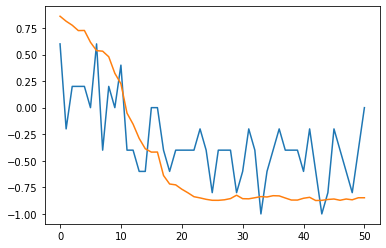

In [21]:
plt.plot(costs_gds[0])
plt.plot(c_exacts[0])

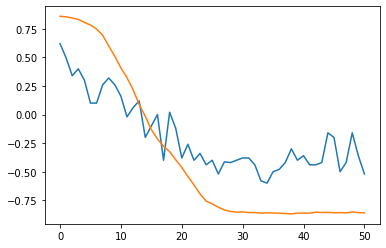

In [22]:
plt.plot(costs_gds[1])
plt.plot(c_exacts[1])

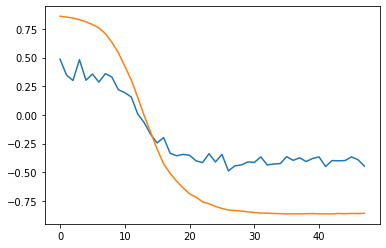

In [23]:
plt.plot(costs_gds[2])
plt.plot(c_exacts[2])

In [24]:
g = np.load("grid.npz")
xs = g["xs"]
ys = g["ys"]
zv = g["zv"]

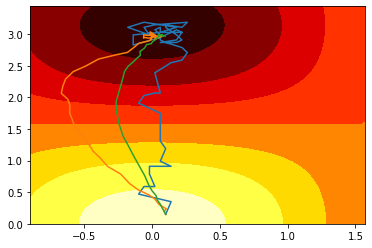

In [25]:
for i in range(3):
    plt.plot(weights_gds[i][:, 0], weights_gds[i][:, 1])

plt.xlim(-0.9, np.pi / 2)
plt.ylim(0, np.pi + 0.3)
    
cmap = plt.get_cmap('hot')
plt.contourf(xs,ys,zv, cmap=cmap)

In [26]:
times_0 = [10 * 4 * i for i in range(len(costs_gds[0]))]
times_1 = [100 * 4 * i for i in range(len(costs_gds[1]))]
times_2 = [1000 * 4 * i for i in range(len(costs_gds[2]))]

In [27]:
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [28]:
with open('../sim/gds_results_3.pickle', "rb") as f:
    res = pickle.load(f)

In [29]:
ideal = np.array(res[0])

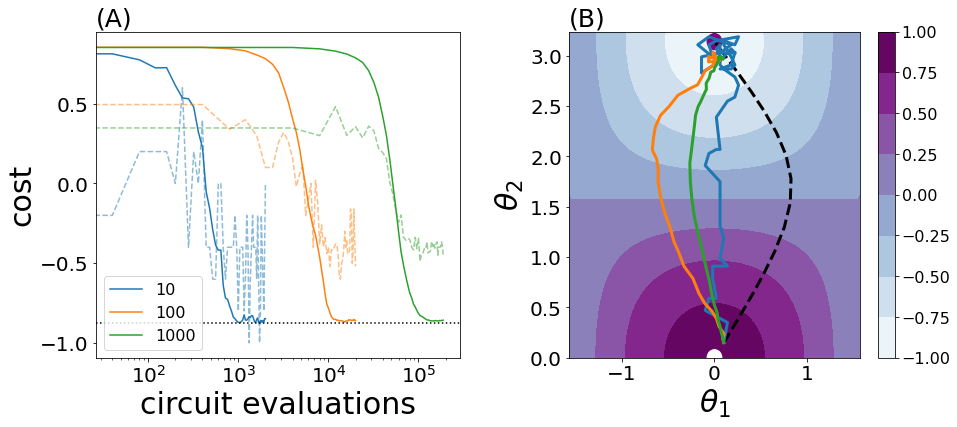

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(times_0, costs_gds[0], "--", c=c[0], alpha=0.5)
axs[0].plot(times_0, c_exacts[0], c=c[0], label="10")
axs[0].plot(times_1, costs_gds[1], "--", c=c[1], alpha=0.5)
axs[0].plot(times_1, c_exacts[1], c=c[1], label="100")
axs[0].plot(times_2, costs_gds[2], "--", c=c[2], alpha=0.5)
axs[0].plot(times_2, c_exacts[2], c=c[2], label="1000")
axs[0].axhline(np.min(zv), linestyle="dotted", color="black")
axs[0].set_xlabel("circuit evaluations", fontsize=30)
axs[0].set_ylabel("cost", fontsize=30)
axs[0].tick_params(labelsize=20)
axs[0].set_xscale("log")
axs[0].legend(fontsize=16)

axs[1].plot(ideal[:, 0], ideal[:, 1], "--", c="black", linewidth=3)

for i in range(3):
    axs[1].plot(weights_gds[i][:, 0], weights_gds[i][:, 1], c=c[i], linewidth=3)

axs[1].set_xlim(-(np.pi / 2), np.pi / 2)
axs[1].set_ylim(0, np.pi + 0.1)
    
cmap = plt.get_cmap('BuPu')
contour = axs[1].contourf(xs,ys,zv, cmap=cmap)
axs[1].set_xlabel(r"$\theta_{1}$", fontsize=30)
axs[1].set_ylabel(r"$\theta_{2}$", fontsize=30)
axs[1].tick_params(labelsize=20)
cbar = fig.colorbar(contour, ax=axs[1])
cbar.ax.tick_params(labelsize=16) 
circle1 = plt.Circle((0, 0), 0.08, color='white')
circle2 = plt.Circle((0, np.pi), 0.08, color='purple')
axs[1].add_artist(circle1)
axs[1].add_artist(circle2)

axs[0].set_title("(A)", fontsize=25, loc="left")
axs[1].set_title("(B)", fontsize=25, loc="left")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
fig.savefig("gds.pdf", bbox_inches='tight')

## Visualizing optimization surface - New

In [31]:
costs_new = []
weights_new = []

for i in range(2, 3):
    with open("new_results_{}.pickle".format(i), "rb") as f:
        ws, res, gs, hs, costs = pickle.load(f)

    costs_new.append(costs)
    weights_new.append(np.array(ws))

In [32]:
costs_new

[[0.742,
  0.644,
  0.528,
  0.37,
  0.15,
  0.098,
  -0.134,
  -0.196,
  -0.32,
  -0.258,
  -0.448,
  -0.272,
  -0.544,
  -0.548,
  -0.628,
  -0.666,
  -0.658,
  -0.672,
  -0.636,
  -0.628,
  -0.656,
  -0.682,
  -0.634,
  -0.584,
  -0.612,
  -0.65,
  -0.638,
  -0.642,
  -0.588,
  -0.578,
  -0.524,
  -0.654,
  -0.646,
  -0.656,
  -0.676,
  -0.676,
  -0.644,
  -0.682,
  -0.654,
  -0.606,
  -0.676,
  -0.654,
  -0.67,
  -0.694,
  -0.686,
  -0.68,
  -0.654,
  -0.64,
  -0.484,
  -0.734,
  -0.644]]

In [33]:
weights_new

[array([[ 1.00000000e-01,  1.50000000e-01,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 2.47498094e-01,  3.36249686e-01,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 4.58168902e-01,  6.27807682e-01,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 5.75780476e-01,  9.12807795e-01,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 6.49932499e-01,  1.21504149e+00,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 6.24667282e-01,  1.49071169e+00,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 5.67448504e-01,  1.71301019e+00,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 4.77851904e-01,  1.95579350e+00,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 3.99969996e-01,  2.15276780e+00,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 3.38569339e-01,  2.28587676e+00,  3.45363120e+00,
    

In [34]:
c_exacts_new = []

for i in range(1):
    c_exact = []
    for w in weights_new[i]:
        c_exact.append(layers[-1](w))
    c_exacts_new.append(c_exact)

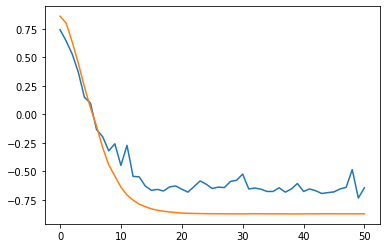

In [35]:
plt.plot(costs_new[0])
plt.plot(c_exacts_new[0])

In [36]:
g = np.load("grid.npz")
xs = g["xs"]
ys = g["ys"]
zv = g["zv"]

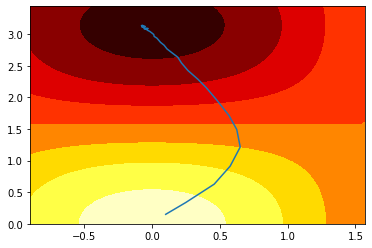

In [37]:
for i in range(1):
    plt.plot(weights_new[i][:, 0], weights_new[i][:, 1])

plt.xlim(-0.9, np.pi / 2)
plt.ylim(0, np.pi + 0.3)
    
cmap = plt.get_cmap('hot')
plt.contourf(xs,ys,zv, cmap=cmap)

## Visualizing optimization surface - New diag

In [38]:
costs_newd = []
weights_newd = []

for i in range(2, 3):
    with open("new_d_results_{}.pickle".format(i), "rb") as f:
        ws, res, gs, hs, costs = pickle.load(f)

    costs_newd.append(costs)
    weights_newd.append(np.array(ws))

In [39]:
costs_newd

[[0.728,
  0.702,
  0.566,
  0.37,
  0.222,
  0.118,
  0.092,
  0.006,
  -0.008,
  0.004,
  -0.09,
  -0.08,
  -0.126,
  -0.18,
  -0.232,
  -0.392,
  -0.362,
  -0.452,
  -0.48,
  -0.496,
  -0.538,
  -0.548,
  -0.428,
  -0.62,
  -0.6,
  -0.644,
  -0.6,
  -0.586,
  -0.66,
  -0.598,
  -0.67,
  -0.638,
  -0.686,
  -0.602,
  -0.56,
  -0.626,
  -0.64,
  -0.662,
  -0.666,
  -0.684,
  -0.602,
  -0.61,
  -0.616,
  -0.636,
  -0.588,
  -0.646,
  -0.618,
  -0.646,
  -0.678,
  -0.692,
  -0.616]]

In [40]:
weights_newd

[array([[ 1.00000000e-01,  1.50000000e-01,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 2.48012232e-01,  2.71533923e-01,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 5.24935309e-01,  4.92558182e-01,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 8.12601343e-01,  7.07071456e-01,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 1.05123771e+00,  9.12444591e-01,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 1.20935535e+00,  1.03678194e+00,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 1.37140226e+00,  1.12833750e+00,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 1.49156687e+00,  1.17452306e+00,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 1.58058534e+00,  1.19364819e+00,  3.45363120e+00,
          2.73521126e+00,  2.64124880e+00],
        [ 1.68205592e+00,  1.18415151e+00,  3.45363120e+00,
    

In [41]:
c_exacts_newd = []

for i in range(1):
    c_exact = []
    for w in weights_newd[i]:
        c_exact.append(layers[-1](w))
    c_exacts_newd.append(c_exact)

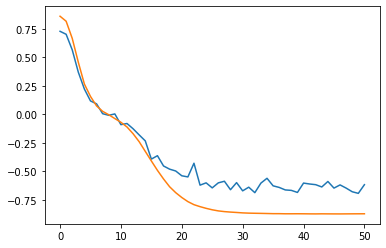

In [42]:
plt.plot(costs_newd[0])
plt.plot(c_exacts_newd[0])

In [43]:
g = np.load("grid.npz")
xs = g["xs"]
ys = g["ys"]
zv = g["zv"]

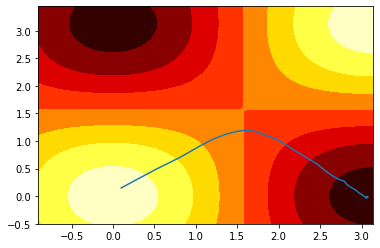

In [44]:
for i in range(1):
    plt.plot(weights_newd[i][:, 0], weights_newd[i][:, 1])

plt.xlim(-0.9, np.pi)
plt.ylim(-0.5, np.pi + 0.3)
    
cmap = plt.get_cmap('hot')
plt.contourf(xs,ys,zv, cmap=cmap)

In [45]:
times_0 = [1000 * i * 4 for i in range(len(costs_gds[2]))]
times_1 = [1000 * i * 9 for i in range(len(costs_new[0]))]
times_2 = [1000 * i * 5 for i in range(len(costs_newd[0]))]

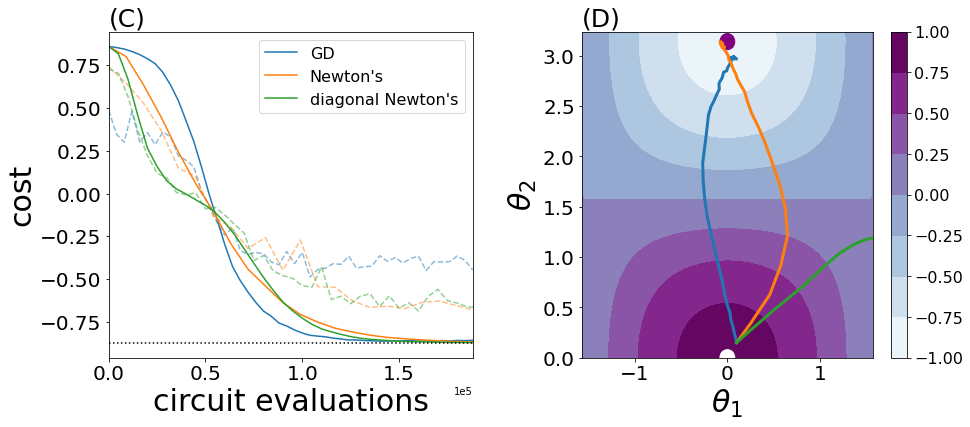

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].plot(times_0, costs_gds[2], "--", c=c[0], alpha=0.5)
axs[0].plot(times_0, c_exacts[2], c=c[0], label="GD")
axs[0].plot(times_1, costs_new[0], "--", c=c[1], alpha=0.5)
axs[0].plot(times_1, c_exacts_new[0], c=c[1], label="Newton's")
axs[0].plot(times_2, costs_newd[0], "--", c=c[2], alpha=0.5)
axs[0].plot(times_2, c_exacts_newd[0], c=c[2], label="diagonal Newton's")
axs[0].axhline(np.min(zv), linestyle="dotted", color="black")
axs[0].set_xlabel("circuit evaluations", fontsize=30)
axs[0].set_ylabel("cost", fontsize=30)
axs[0].tick_params(labelsize=20)
axs[0].set_xlim(0, times_0[-1])
axs[0].legend(fontsize=16)
axs[0].ticklabel_format(style='sci',scilimits=(-3,4),axis='both')

axs[1].plot(weights_gds[2][:, 0], weights_gds[2][:, 1], c=c[0], linewidth=3)
axs[1].plot(weights_new[0][:, 0], weights_new[0][:, 1], c=c[1], linewidth=3)
axs[1].plot(weights_newd[0][:, 0], weights_newd[0][:, 1], c=c[2], linewidth=3)

axs[1].set_xlim(-(np.pi / 2), np.pi / 2)
axs[1].set_ylim(0, np.pi + 0.1)
    
cmap = plt.get_cmap('BuPu')
contour = axs[1].contourf(xs,ys,zv, cmap=cmap)
axs[1].set_xlabel(r"$\theta_{1}$", fontsize=30)
axs[1].set_ylabel(r"$\theta_{2}$", fontsize=30)
axs[1].tick_params(labelsize=20)
cbar = fig.colorbar(contour, ax=axs[1])
cbar.ax.tick_params(labelsize=16) 
circle1 = plt.Circle((0, 0), 0.08, color='white')
circle2 = plt.Circle((0, np.pi), 0.08, color='purple')
axs[1].add_artist(circle1)
axs[1].add_artist(circle2)

axs[0].set_title("(C)", fontsize=25, loc="left")
axs[1].set_title("(D)", fontsize=25, loc="left")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
fig.savefig("comparison.pdf", bbox_inches='tight')